In [18]:
%reload_ext autoreload
%autoreload 2
import model_lib
from sampling_methods.constants import AL_MAPPING
from sampling_methods.constants import get_AL_sampler
from sampling_methods.constants import get_wrapper_AL_mapping
from sampling_methods.constants import get_base_AL_mapping
from utils import utils

In [19]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import shap



In [20]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
from modAL.models import ActiveLearner, Committee

import copy

from sklearn.datasets import make_classification
from alipy import ToolBox

import joblib


In [106]:
from sampling_methods.constants import AL_MAPPING
from sampling_methods.constants import get_AL_sampler
from sampling_methods.constants import get_wrapper_AL_mapping
from sampling_methods.constants import get_base_AL_mapping
from utils import utils

In [70]:
get_base_AL_mapping()

In [71]:
import numpy as np
from flask import Flask, request, jsonify
import pandas as pd
from io import StringIO
import joblib
from sklearn.preprocessing import StandardScaler
from deepod.models import PReNet
from itertools import combinations
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from alipy import ToolBox

features = ['Src IP', 'Dst IP','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)
    

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    # zero_variance_cols = []
    # for col in df.columns:
    #     if len(df[col].unique()) == 1:
    #         zero_variance_cols.append(col)
    # df.drop(zero_variance_cols, axis = 1, inplace = True)
    # print('zero variance columns', zero_variance_cols, 'dropped')
    # print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    # ide_cols = []
    # for column_pair in column_pairs:
    #     ide_cols.append(column_pair[1])
    # df.drop(ide_cols, axis = 1, inplace = True)
    # print('columns which have identical values', column_pairs, 'dropped')
    # print('shape after removing identical value columns:', df.shape)
    return df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def read_csv(folder_names = ['dripper/', 'BENIGN/', 'bonesi/']):
    full_df = pd.DataFrame()
    dataset_csv_path = './Dataset/SimulatedCVE/cicflowmeter_cve/'
    for folder in folder_names:

        csv_file_names = os.listdir("Dataset/SimulatedCVE/cicflowmeter_cve/" + folder)
        complete_paths = []
        for csv_file_name in csv_file_names:
            complete_paths.append(os.path.join(dataset_csv_path+folder, csv_file_name))
        print(complete_paths)
        df = pd.concat(map(pd.read_csv, complete_paths), 
                                ignore_index = True)
        if folder == 'training_data/gm/': #Avoid Dst IP and Src IP when loading from training folder
            df = df[features[2:]].copy()
        else:
            df = df[features].copy()
        print(folder[:-1])
        df["Label"] = folder[:-1]
        df["Label"] = df["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)
        full_df = pd.concat([full_df, df], axis=0, ignore_index=True)
    label = full_df["Label"]    
    
    cleaned_df = clean_df(full_df)
    # Drop String Columns
    cleaned_df = cleaned_df[features]
    # cleaned_df = cleaned_df.drop(columns=['Src IP', 'Dst IP', "Label"])
    # Remove Inf and Nan
    # cleaned_df = cleaned_df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
    # cleaned_df = cleaned_df.fillna(df.mean())
    # cleaned_df.dropna(inplace=True)
    # cleaned_df = cleaned_df.select_dtypes(include=[np.number])
    # indices_to_keep = ~cleaned_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    # cleaned_df = cleaned_df[indices_to_keep]
    # Reinsert the label
    cleaned_df["Label"] = label
    cleaned_df.to_csv("x.csv")
    return cleaned_df
  
  
def validated_req_schema(flow_data):
  df_pruned = flow_data[features]
  return df_pruned  


  

def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
  
def eval_accuracy(clf, X_test, y_test):
    anomaly_scores = clf.decision_function(X_test.to_numpy())
    print("AASDDAS",anomaly_scores)
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    f1 = f1_score(y_test, pred)
    conf_matrix = confusion_matrix(y_test, pred)
    print(f"F1 Score: {f1:.4f}")
    print(conf_matrix)
    return opt_threshold
def get_avail_filename(folder,filename):
    filenumber = 0
    filepath = os.path.join(folder,f"{filename}_{filenumber}.csv")
    while os.path.exists(filepath):
        filenumber+=1
        filepath = os.path.join(folder, f"{filename}_{filenumber}.csv")  
    print(filepath)  
    return filepath

def load_data(train_folder,scaler=None):
    full_df = read_csv(train_folder)
    # validated_df = validated_req_schema(full_df)
    label = full_df["Label"].values
    full_df.drop(columns=["Src IP", "Dst IP", "Label"], axis=1, inplace=True)
    columns = full_df.columns
    if scaler != None:
        normalized_data = scaler.transform(full_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = full_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    

    
    
class Global_Model():
  def __init__(self, train_folder = ['dripper/', 'BENIGN/', 'bonesi/', 'training_data/gm/']):
    self.scaler = joblib.load('cic_scaler.joblib')
    self.train_folder = train_folder

    self.model, self.opt_threshold = self.load_model()
    
    
  def load_data(self,scaler=None):
    full_df = read_csv(self.train_folder)
    # validated_df = validated_req_schema(full_df)
    label = full_df["Label"].values
    full_df.drop(columns=["Src IP", "Dst IP", "Label"], axis=1, inplace=True)
    columns = full_df.columns
    if scaler != None:
        normalized_data = scaler.transform(full_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = full_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    
    # TODO: New Data Handling - Append the data to the gm_training.csv
    
  def load_model(self): # Load the model through training since pytorch isn't supported
    model = PReNet
    clf = model(epochs=1, device='cuda')
    X_train, X_test, y_train, y_test = self.load_data(self.scaler)
    clf.fit(X_train.to_numpy()[:10000], y_train[:10000])
    
    opt_threshold = eval_accuracy(clf, X_test, y_test)
    return clf, opt_threshold
            
      
  def perform_inference(self, X):
    X_scaled = self.scaler.transform(X) # ! Add Scaler
    anomaly_scores = self.model.decision_function(X_scaled)
    output = np.where(anomaly_scores > self.opt_threshold, 1,0)
    print(np.unique(output)) 
    return output

  def update_data(self,X):
    #Write a new CSV FIle
    folder = self.train_folder[-1]
    filename = get_avail_filename(folder, "gm_train_data")
    filepath = os.path.join("Dataset/SimulatedCVE/cicflowmeter_cve/", filename)
    X.to_csv(filepath, index=False)
    
    print(f"Added {filepath} as New GM Training Data")
      
  def retrain_gm(self, X):
    X_scaled = self.scaler.transform(X)

class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic', verbosity=0)
        # self.model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
        #                                     min_samples_leaf=10, 
        #                                     # ccp_alpha=0.01, #Pruning coef
        #                                     random_state=4022)
        # self.model = RandomForestClassifier(criterion='entropy', 
        #                                     n_estimators=200,
        #                                     random_state=4022)
        # self.model = SVC(kernel='rbf', 
        #                 gamma='scale',  # You can also use 'auto' depending on the specific setting mentioned
        #                 C=1.0,  # Default regularization parameter, adjust as needed
        #                 probability=True,
        #                 random_state=4022)                
        self.train_folder = "./Dataset/SimulatedCVE/cicflowmeter_cve/training_data/lm/"
        self.model_path = "./cic_xgb.joblib"
        self.state = 0 #0: OFF, 1: ON, 2: HYBRID
        self.scaler = joblib.load('./cic_scaler.joblib')
        self.global_model = gm #Replace With HTTP API
        self.load_model()
    def load_model(self):
        # self.model = joblib.load(self.model_path)
        known_df = self.load_known_df()
        y_known = known_df["Label"]
        X_known = known_df.drop(columns=["Label"], inplace=False)
        X_known = X_known[features[2:]]
        X_known_scaled = self.scaler.transform(X_known)
        self.model.fit(X_known_scaled, y_known)
        
    def load_known_df(self):
        known_df = pd.DataFrame()
        training_data_list = os.listdir(self.train_folder)
        training_data_list.sort(reverse=True)
        # known_df =  pd.read_csv(os.path.join(self.train_folder,training_data_list[0]))
        # print(training_data_list[0])
        if len(training_data_list) > 0:
            print(training_data_list)
            for training_data in training_data_list:
                curr_df = pd.read_csv(os.path.join(self.train_folder,training_data))
                known_df = pd.concat([known_df, curr_df], axis=0, ignore_index=True)      
        # known_df.drop(columns=["Src IP", "Dst IP"], inplace=True)
        return known_df  
                
    def retrain_model(self, X_new, y_new=None, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        known_df = self.load_known_df()
        filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        if update_gm:
            filtered_new_data["Label"] = 0
            self.global_model.update_data(filtered_new_data)
        # TODO: After updating return the labels or recall the function
        else:
            self.append_training_data(filtered_new_data)
            # Update the model        
            self.model = updated_model # ! If update_gm, should replace the previous record for AL to work
        return informative_score_list
        
    def upload_gm(self, X_query): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label = self.global_model.perform_inference(X_query)
        X_query_df = pd.DataFrame(X_query, columns=features[2:])
        X_query_df["Label"] = pseudo_label
        return pseudo_label
    def select_data(self, known_df, X_new, threshold, y_new):
        round = 10
        informative_score_list = []
        y_new = np.ones(X_new.shape[0]) * 2 if y_new is None else y_new
        model = self.model
        
        X_known = known_df.drop(columns=["Label"], inplace = False).copy()
        y_known = known_df["Label"]
        # X_known.drop(columns=["Src IP", "Dst IP"], inplace=True)
        X = pd.concat([X_known, X_new], ignore_index=True)
        y = np.concatenate([y_known, y_new]).astype(int)
        print(y)
        label_ind = np.arange(len(X_known))
        print("Size of Label Index", len(X_known))
        unlab_ind = np.arange(len(X_known), len(X))

        divided_arrays = np.array_split(unlab_ind, round)
        
        alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,) 
        alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=10)     
        strategy_name = "QueryInstanceUncertainty"
        strategy = alibox_new.get_query_strategy(strategy_name=strategy_name) #TODO Replace Alibox with a single function
        for i in range(round):
            batch_size = 1000 
            print(f"Round {i}")
            # Use AL to Select Data

            
            select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=divided_arrays[i], 
                                                            threshold=threshold, custom = True, model=model, batch_size=batch_size)
            print(select_ind)
            # select_ind = select_ind[np.where(np.array(informative_score) > threshold)[0]]
                              
            batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
            print(batch_size)
            # Upload Data to GM
            idx_to_query = select_ind[:batch_size]
            if len(idx_to_query) > 0:
                if 2.0 in y_new: 
                    pseudo_labels = self.upload_gm(X.iloc[idx_to_query]) 
                    y[idx_to_query] = pseudo_labels 
                else: # ? Set GM to be 100% Accurate
                    pseudo_labels = y[idx_to_query]
                    # y[idx_to_query] = pseudo_labels
                print(f"New Label Counts: {Counter(y[select_ind[:batch_size]])}")    
                label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
                mask = np.where(np.isin(unlab_ind, select_ind[:batch_size], invert=True)) # unlab_ind.difference_update(select_ind)
                unlab_ind = unlab_ind[mask]
                
                print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
                #Update The Model
                X_scaled = self.scaler.transform(X.iloc[label_ind]) 
                print("Number of duplicates", len(label_ind) - len(np.unique(label_ind)))
                model = self.model
                print(label_ind)
                print(f"np.unique: {np.unique(y[label_ind])}")
                model.fit(X=X_scaled, y=y[label_ind]) 
                # pred = model.predict(X_test)
                # query_accuracy = metric(pred, y_test)      
            else:
                print("No Data Added")
            print(informative_score[:100])
            informative_score_list.append(informative_score)

            
        merged_train_df = pd.DataFrame(X.iloc[label_ind], columns = features[2:])
        merged_train_df["Label"] = y[label_ind]
        new_train_df = merged_train_df.iloc[len(X_known):]
        return new_train_df, informative_score_list, model
        
    def perform_inference(self, X):
            X_scaled = self.scaler.transform(X) # ! Add Scaler
            output = self.model.predict(X_scaled) 
            print(np.unique(output)) 
            return output
    def append_training_data(self,new_train_df):
        #Write a new CSV FIle
        folder = self.train_folder
        filepath = get_avail_filename(folder, "lm_train_data")
        new_train_df.to_csv(filepath, index=False)
        print(f"Added {filepath} as New LM Training Data")

        

## Google Active Learning

In [42]:
scaler = joblib.load("cic_scaler.joblib")
X_train, X_test, y_train, y_test = load_data(train_folder=['dripper/', 'BENIGN/', 'bonesi/'])
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)
np.unique(y_train)

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 64)
4835 rows dropped
shape after removing nan: (399914, 64)
shape after dropping duplicates: (285043, 64)


array([0, 1])

In [8]:
gm = Global_Model(['dripper/', 'BENIGN/', 'bonesi/'])

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 64)
4835 rows dropped
shape after removing nan: (399914, 64)
shape after dropping duplicates: (285043, 64)
Start Training...
ensemble size: 1
DualInputNet(
  (enc_net): MLPnet(
    (netw

testing: 100%|██████████| 891/891 [00:07<00:00, 124.49it/s]

AASDDAS [1.66635215 1.97627985 6.18899298 ... 6.6637454  6.18383646 1.98207819]
F1 Score: 0.9530
[[27572   451]
 [ 2191 26795]]


In [94]:
lm = Local_Model(gm)

['lm_train_data_1.csv', 'lm_train_data_0.csv']


In [99]:
get_wrapper_AL_mapping()
get_base_AL_mapping()
def select_batch(sampler, uniform_sampler, mixture, N, already_selected,
                  **kwargs):
  n_active = int(mixture * N)
  n_passive = N - n_active
  kwargs["N"] = n_active
  kwargs["already_selected"] = already_selected
  batch_AL, min_margin = sampler.select_batch(**kwargs)
  batch_AL = list(batch_AL)
  already_selected = already_selected + batch_AL
  kwargs["N"] = n_passive
  kwargs["already_selected"] = already_selected
  batch_PL = uniform_sampler.select_batch(**kwargs)
  batch_PL = list(batch_PL)
  print(f"AL:{len(batch_AL)}, PL:{batch_PL}")
  return batch_AL + batch_PL, min_margin

seed = 4022
rounds = 10
sampling_method = "informative_diverse"#FLAGS.sampling_method
#?score_model = XGBClassifier(objective="binary:logistic")
score_model = lm.model
select_model = score_model
active_p = 1.0 # Percentage of batch to allocate for active learning
selected_inds = [0] # label_ind

train_size = 0.8*len(y_train)
batch_size = 1000 #Percentage of training size
if batch_size < 1:
  batch_size = int(batch_size * train_size)
else:
  batch_size = int(batch_size)
n_sample = min(batch_size, train_size - len(selected_inds))
accuracy = []
informative_score_list = []
divided_arrays = np.array_split(np.arange(len(X_train_scaled)), rounds)




In [100]:
import cProfile
import pstats
profiler = cProfile.Profile()
profiler.enable()
for round in range(rounds):
    curr_round_idx = np.concatenate([selected_inds, divided_arrays[0]]).astype(int)
    X_curr_round = X_train_scaled.iloc[curr_round_idx]
    y_curr_round = y_train[curr_round_idx]
    sampler = get_AL_sampler(sampling_method)
    sampler = sampler(X_curr_round, y_curr_round, seed)
    uniform_sampler = AL_MAPPING["uniform"](X_curr_round, y_curr_round, seed)

    # TODO Implement Loop
    select_batch_inputs = {
        "model": select_model,
        "labeled": dict(zip(selected_inds, y_train[selected_inds])),
        "X_test": X_test_scaled,
        "y_test": y_test,
        "y": y_train
    }
    new_batch, min_margin = select_batch(sampler, uniform_sampler, active_p, n_sample, #? Outputs the last indices because all data are important initially
                                selected_inds, **select_batch_inputs) 
    #! use of select_model on informative_diverse?
    # Update Selected Index
    selected_inds.extend(new_batch)
    print('Round %d, Requested: %d, Selected: %d out of %d'  % (round, n_sample, len(new_batch), len(y_curr_round)))
    # Update The Model
    score_model.fit(X_train_scaled.iloc[selected_inds], y_train[selected_inds], verbose=0)
    select_model = score_model
    # Track the informative_score every round
    informative_score_list.append(min_margin)
profiler.disable()

# Save the profiling results to a file
profile_file = 'profiling_results.prof'
profiler.dump_stats(profile_file)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 0, Requested: 1000, Selected: 1000 out of 22805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 1, Requested: 1000, Selected: 1000 out of 23805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 2, Requested: 1000, Selected: 1000 out of 24805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 3, Requested: 1000, Selected: 1000 out of 25805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 4, Requested: 1000, Selected: 1000 out of 26805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 5, Requested: 1000, Selected: 1000 out of 27805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 6, Requested: 1000, Selected: 1000 out of 28805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 7, Requested: 1000, Selected: 1000 out of 29805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 8, Requested: 1000, Selected: 1000 out of 30805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 9, Requested: 1000, Selected: 1000 out of 31805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [101]:
len(selected_inds)
len(np.unique(selected_inds))

10001

10001

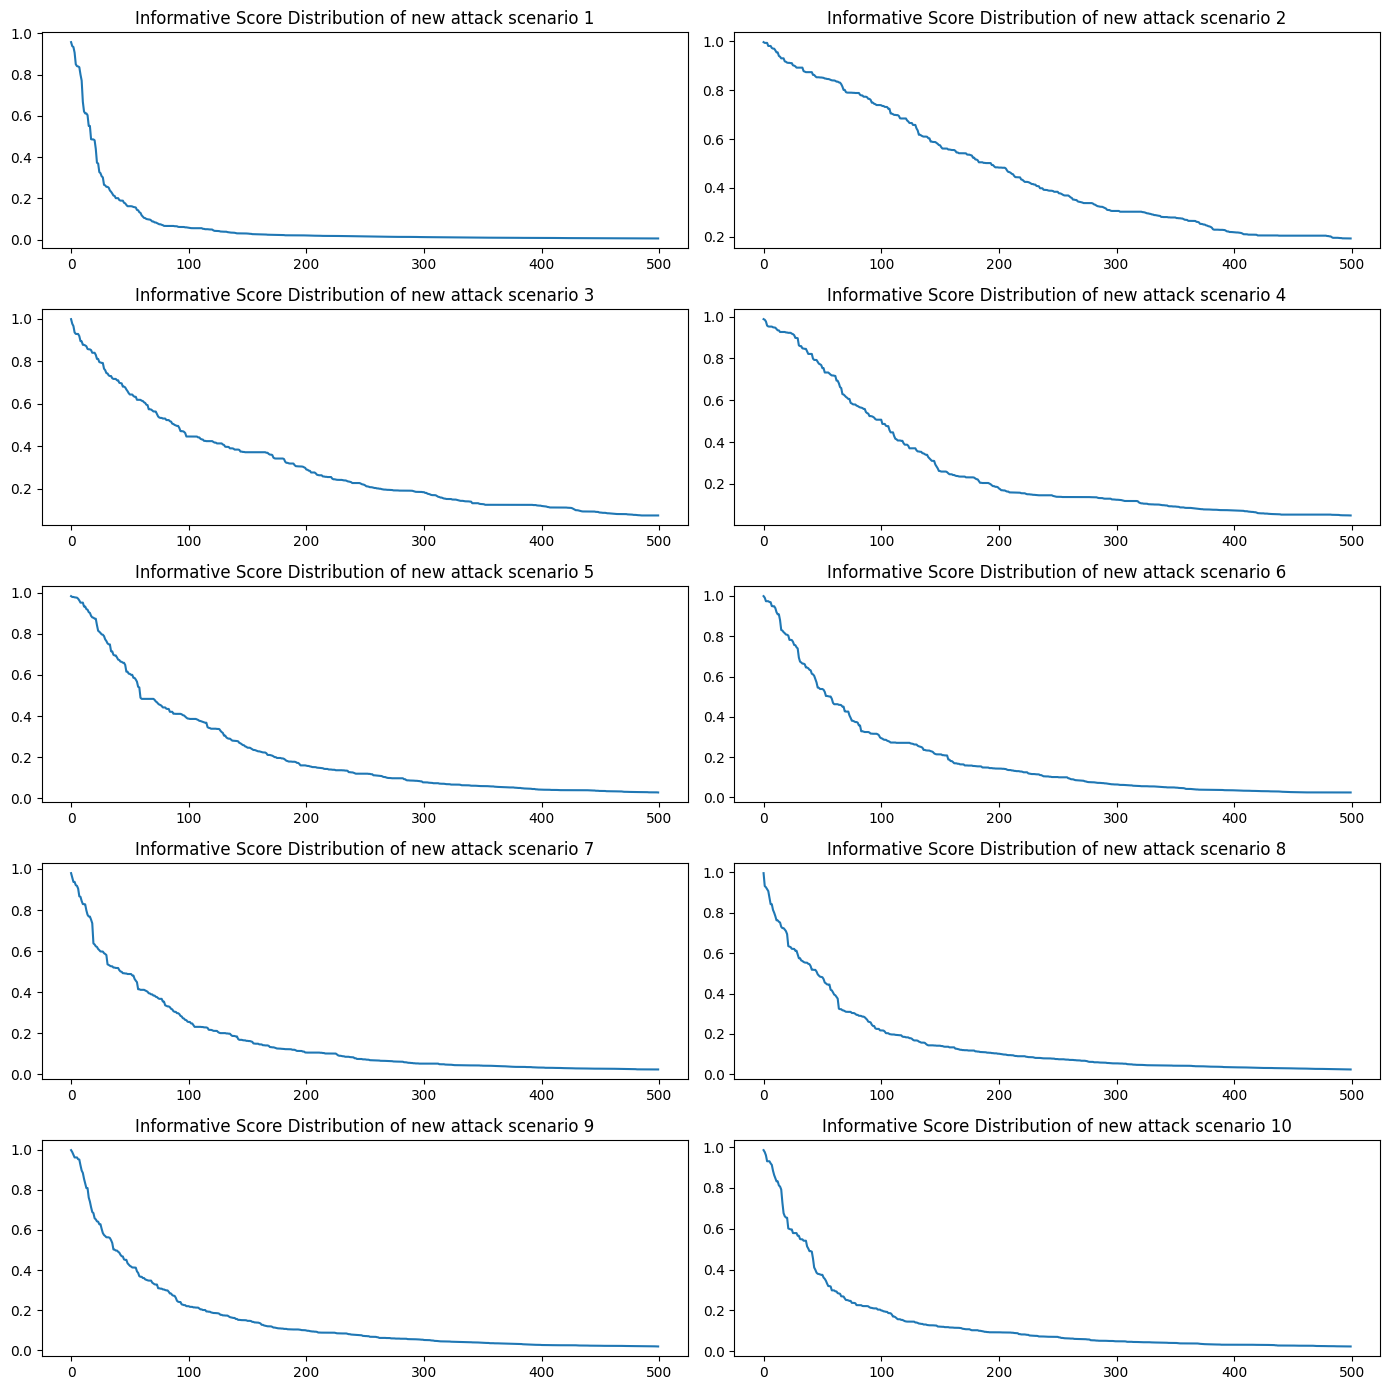

In [102]:
def plot_supporting_scores(informative_score_list, n_times=10, sort=True):

    
    fig, axes = plt.subplots(n_times//2, 2, figsize=(14, 14))  # Create 5x2 subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(n_times):
      informative_arr = np.array(informative_score_list[i])
      if sort:
        informative_arr = -np.sort(informative_arr-1)[:500]
        axes[i].plot(np.arange(len(informative_arr)), informative_arr)
        axes[i].set_title(f"Informative Score Distribution of new attack scenario {i + 1}")

    plt.tight_layout()
    plt.show()
    
plot_supporting_scores(informative_score_list,10)

## New Data

In [103]:
X_train, X_test, y_train, y_test = load_data(train_folder=["BENIGN/", "goldeneye/"])
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)
np.unique(y_train)

['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeneye
dataset shape (237140, 64)
825 rows dropped
shape after removing nan: (236315, 64)
shape after dropping duplicates: (161314, 64)


array([0, 1])

In [104]:
import cProfile
import pstats
profiler = cProfile.Profile()
profiler.enable()
for round in range(rounds):
    curr_round_idx = np.concatenate([selected_inds, divided_arrays[0]]).astype(int)
    X_curr_round = X_train_scaled.iloc[curr_round_idx]
    y_curr_round = y_train[curr_round_idx]
    sampler = get_AL_sampler(sampling_method)
    sampler = sampler(X_curr_round, y_curr_round, seed)
    uniform_sampler = AL_MAPPING["uniform"](X_curr_round, y_curr_round, seed)

    # TODO Implement Loop
    select_batch_inputs = {
        "model": select_model,
        "labeled": dict(zip(selected_inds, y_train[selected_inds])),
        "X_test": X_test_scaled,
        "y_test": y_test,
        "y": y_train
    }
    new_batch, min_margin = select_batch(sampler, uniform_sampler, active_p, n_sample, #? Outputs the last indices because all data are important initially
                                selected_inds, **select_batch_inputs) 
    #! use of select_model on informative_diverse?
    # Update Selected Index
    selected_inds.extend(new_batch)
    print('Round %d, Requested: %d, Selected: %d out of %d'  % (round, n_sample, len(new_batch), len(y_curr_round)))
    # Update The Model
    score_model.fit(X_train_scaled.iloc[selected_inds], y_train[selected_inds], verbose=0)
    select_model = score_model
    # Track the informative_score every round
    informative_score_list.append(min_margin)
profiler.disable()

# Save the profiling results to a file
profile_file = 'profiling_results.prof'
profiler.dump_stats(profile_file)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 0, Requested: 1000, Selected: 1000 out of 32805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 1, Requested: 1000, Selected: 1000 out of 33805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 2, Requested: 1000, Selected: 1000 out of 34805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 3, Requested: 1000, Selected: 1000 out of 35805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 4, Requested: 1000, Selected: 1000 out of 36805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 5, Requested: 1000, Selected: 1000 out of 37805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 6, Requested: 1000, Selected: 1000 out of 38805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 7, Requested: 1000, Selected: 1000 out of 39805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 8, Requested: 1000, Selected: 1000 out of 40805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


AL:1000, PL:[]
Round 9, Requested: 1000, Selected: 1000 out of 41805


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

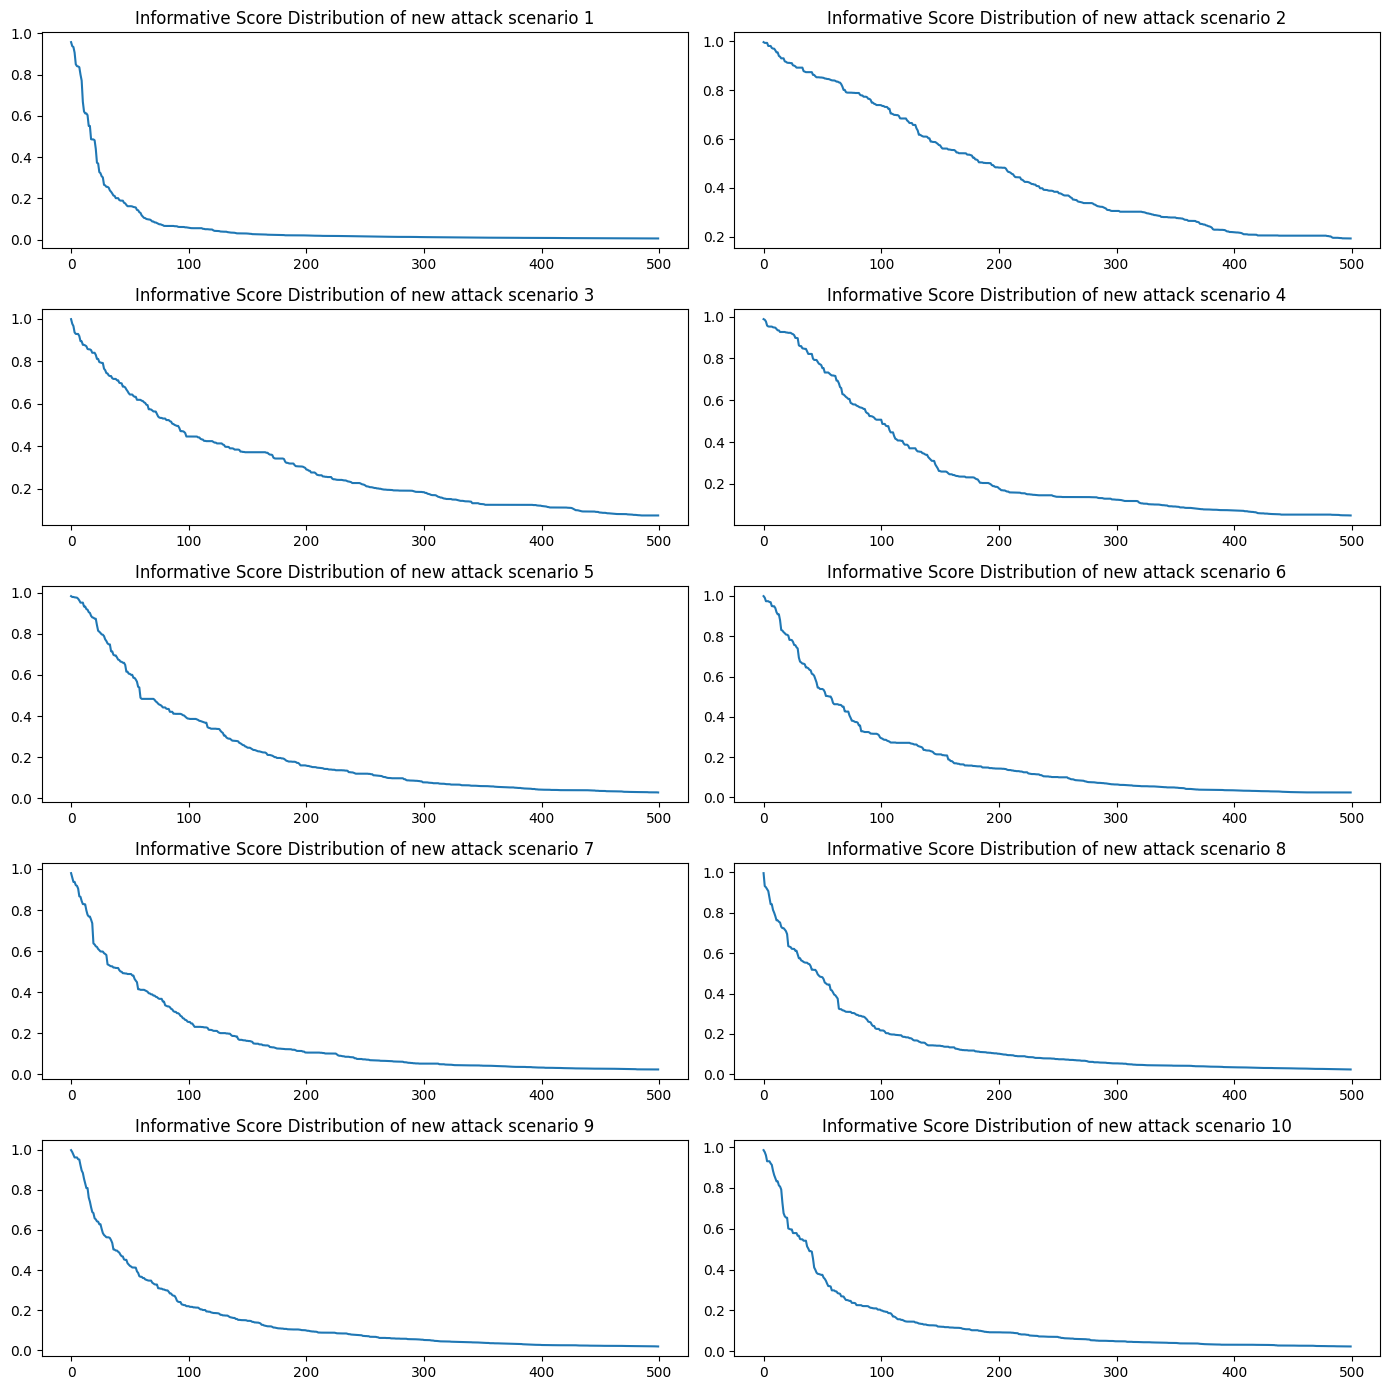

In [105]:
plot_supporting_scores(informative_score_list,10)